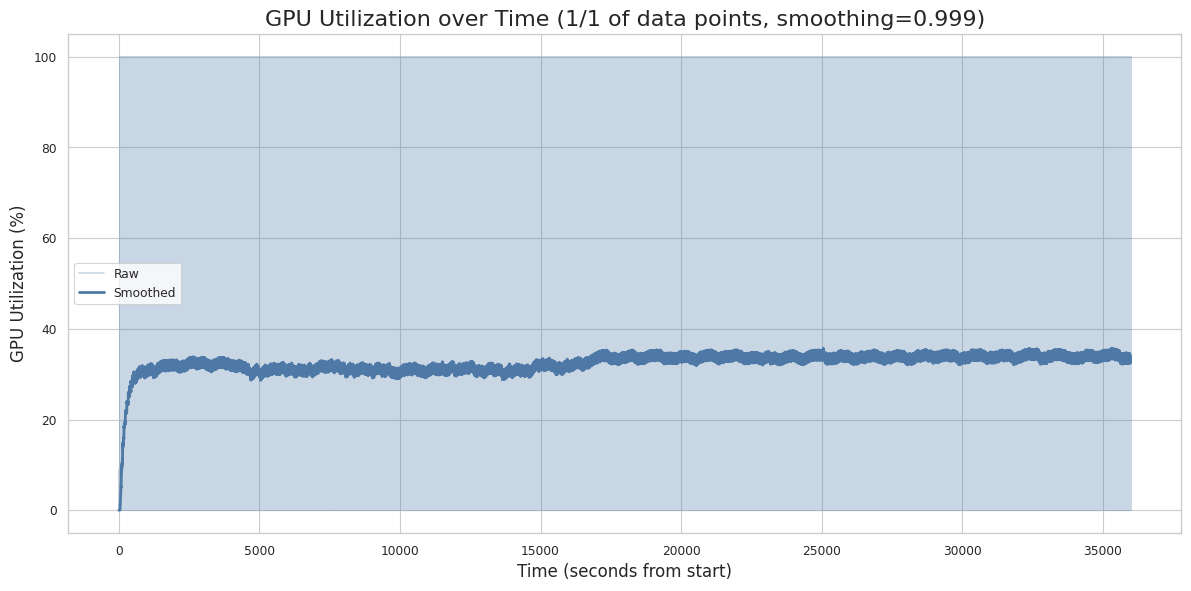

In [25]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def wandb_smooth(array, weight=0.6):
    last = array[0]
    smoothed = np.zeros(len(array))
    for i, point in enumerate(array):
        smoothed_val = last * weight + (1 - weight) * point
        smoothed[i] = smoothed_val
        last = smoothed_val
    return smoothed

def plot_smoothed(csv_path, downsample_factor=1, smoothing_weight=0.6):
    # load the data
    df = pd.read_csv(csv_path)
    
    # convert timestamp to datetime
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')
    
    # normalize time to start at 0
    start_time = df['timestamp'].min()
    df['normalized_time'] = (df['timestamp'] - start_time).dt.total_seconds()
    
    # downsample
    df_downsampled = df.iloc[::downsample_factor]
    
    # apply smoothing
    df_downsampled['gpu_util_smooth'] = wandb_smooth(df_downsampled['gpu_util'], smoothing_weight)
    
    # set the style
    sns.set_style("whitegrid")
    sns.set_context("paper")
    
    # create the plot
    plt.figure(figsize=(12, 6))
    sns.lineplot(x='normalized_time', y='gpu_util', data=df_downsampled, 
                 color='#4e79a7', alpha=0.3, label='Raw')
    sns.lineplot(x='normalized_time', y='gpu_util_smooth', data=df_downsampled, 
                 color='#4e79a7', linewidth=2, label='Smoothed')
    
    # customize
    plt.title(f'GPU Utilization over Time (1/{downsample_factor} of data points, smoothing={smoothing_weight})', 
              fontsize=16)
    plt.xlabel('Time (seconds from start)', fontsize=12)
    plt.ylabel('GPU Utilization (%)', fontsize=12)
    plt.legend()
    
    # add a bit of padding
    plt.tight_layout()
    
    # show the plot
    plt.show()

# usage
plot_smoothed("baseline-2024-06-26_15-14/gpu.csv", downsample_factor=1, smoothing_weight=0.999)

In [103]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import SVG, display

def plot_one_minute(csv_path, output_path, shift_time=0, polling_rate=10, smoothing_weight=0.6):
    # load and process data
    df = pd.read_csv(csv_path)
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')
    start_index = shift_time * polling_rate
    end_index = start_index + (60 * polling_rate)
    df_minute = df.iloc[start_index:end_index].copy().reset_index(drop=True)
    df_minute['seconds'] = df_minute.index / polling_rate
    df_minute['gpu_util_smooth'] = wandb_smooth(df_minute['gpu_util'], smoothing_weight)
    
    # create the plot
    plt.figure(figsize=(8, 6))
    sns.lineplot(x='seconds', y='gpu_util', data=df_minute, 
                 color='#2ca02c', alpha=0.5, label='Raw')
    sns.lineplot(x='seconds', y='gpu_util_smooth', data=df_minute, 
                 color='#4e79a7', linewidth=2, label='Smoothed')
    
    # customize
    plt.xlabel('Time (seconds)', fontsize=12)
    plt.ylabel('GPU Utilization (%)', fontsize=12)
    plt.xlim(0, 60)
    plt.legend()
    plt.tight_layout()
    
    # save to file
    plt.savefig(output_path, format='svg')
    plt.close()

In [101]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import SVG, display

def wandb_smooth(array, weight=0.6):
    last = array[0]
    smoothed = np.zeros(len(array))
    for i, point in enumerate(array):
        smoothed_val = last * weight + (1 - weight) * point
        smoothed[i] = smoothed_val
        last = smoothed_val
    return smoothed

def plot_full_dataset(csv_path, output_path, smoothing_weight=0.6):
    # load the data
    df = pd.read_csv(csv_path)
    
    # convert timestamp to datetime
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')
    
    # calculate seconds from start
    df['seconds'] = (df['timestamp'] - df['timestamp'].min()).dt.total_seconds()
    
    # apply smoothing
    df['gpu_util_smooth'] = wandb_smooth(df['gpu_util'], smoothing_weight)
    
    # set the style
    sns.set_style("whitegrid")
    sns.set_context("paper")
    
    # create the plot
    plt.figure(figsize=(8, 6))  # larger figure for full dataset
    sns.lineplot(x='seconds', y='gpu_util_smooth', data=df, 
                 color='#4e79a7', linewidth=2, label='Smoothed')
    
    # customize
    plt.xlabel('Time (seconds)', fontsize=12)
    plt.ylabel('GPU Utilization (%)', fontsize=12)
    plt.legend()
    
    # add a bit of padding
    plt.tight_layout()
    
    # save as svg
    plt.savefig(output_path, format='svg')
    plt.close()  # close the plot to free up memory

In [104]:
smoothing = 0.999
shift = 1000

svg_path = "./svg/gpu_util"
svg_path_disk = svg_path + "gpu_util_minute_disk.svg"
svg_path_baseline = svg_path + "gpu_util_minute_baseline.svg"
svg_path_wirehead_local =  svg_path + "gpu_util_minute_wirehead_local.svg"
svg_path_wirehead_distributed = svg_path + "gpu_util_minute_wirehead.svg"

plot_one_minute("disk-2024-07-02_17-06/gpu.csv", svg_path_disk, shift_time=100, polling_rate=10, smoothing_weight=smoothing)
plot_one_minute("baseline-2024-06-26_15-14/gpu.csv", svg_path_baseline, shift_time=shift, polling_rate=10, smoothing_weight=smoothing)
plot_one_minute("wirehead_train-2024-06-25_20-07/gpu.csv", svg_path_wirehead_local, shift_time=shift, polling_rate=10, smoothing_weight=smoothing)
plot_one_minute("multigpu_gen-2024-06-27_01-37/gpu.csv", svg_path_wirehead_distributed, shift_time=shift, polling_rate=10, smoothing_weight=smoothing)

In [99]:
smoothing = 0.999

svg_path = "./svg/gpu_util/"
svg_path_disk = svg_path + "gpu_util_full_disk.svg"
svg_path_baseline = svg_path + "gpu_util_full_baseline.svg"
svg_path_wirehead_local = svg_path + "gpu_util_full_wirehead_local.svg"
svg_path_wirehead_distributed = svg_path + "gpu_util_full_wirehead.svg"

plot_full_dataset("disk-2024-07-02_17-06/gpu.csv", svg_path_disk, smoothing_weight=smoothing)
plot_full_dataset("baseline-2024-06-26_15-14/gpu.csv", svg_path_baseline, smoothing_weight=smoothing)
plot_full_dataset("wirehead_train-2024-06-25_20-07/gpu.csv", svg_path_wirehead_local, smoothing_weight=smoothing)
plot_full_dataset("multigpu_gen-2024-06-27_01-37/gpu.csv", svg_path_wirehead_distributed, smoothing_weight=smoothing)